# Imports

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import itertools
from PIL import Image

In [2]:
class AdaIN(nn.Module):
    def __init__(self, num_features, style_dim=256):
        super(AdaIN, self).__init__()
        self.norm = nn.InstanceNorm2d(num_features)
        self.style = nn.Parameter(torch.randn(1, style_dim, 1, 1))

    def forward(self, x):
        normalized = self.norm(x)
        style = self.style.repeat(x.size(0), 1, x.size(2), x.size(3))
        x = normalized * (1 + style)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            AdaIN(in_features),
        )

    def forward(self, x):
        out = self.block(x)
        return x + out

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=6, noise=True):
        super(Generator, self).__init__()

        # Initial convolution block
        initial_layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        down_layers = []
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            down_layers += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        residual_blocks = []
        for _ in range(n_residual_blocks):
            residual_blocks += [ResidualBlock(in_features)]

        # Upsampling
        up_layers = []
        out_features = in_features // 2
        for _ in range(2):
            up_layers += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        output_layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]

        # Combine all layers
        self.initial = nn.Sequential(*initial_layers)
        self.down = nn.Sequential(*down_layers)
        self.residual_blocks = nn.Sequential(*residual_blocks)
        self.up = nn.Sequential(*up_layers)
        self.output = nn.Sequential(*output_layers)

        self.noise = noise

    def forward(self, x):
        x = self.initial(x)
        x = self.down(x)
        if self.noise:
            x = x + torch.randn_like(x) * 0.2  # Adding noise
        x = self.residual_blocks(x)
        x = self.up(x)
        x = self.output(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        model += [nn.Conv2d(256, 512, 4, padding=1)]

        self.model = nn.Sequential(*model)
        self.output_shape = (1, 256 // 2 ** 3, 256 // 2 ** 3)

    def forward(self, x):
        return self.model(x)

# Custom Dataset class
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self._load_images()

    def _load_images(self):
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image
    
import random
import torchvision
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data:
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return to_return

In [3]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_nc = 3  # Number of channels in input images
output_nc = 3  # Number of channels in output images
lr = 0.0002  # Learning rate
batch_size = 1  # Batch size
  # Number of epochs
decay_epoch = 100  # Start decaying learning rate after this epoch
n_cpu = 8  # Number of CPU threads to use during batch generation
# Define hyperparameters
lambda_cyc = 10  # Weight for cycle consistency loss
lambda_id = 5    # Weight for identity loss

# Initialize generator and discriminator
G_AB = Generator(input_nc, output_nc).to(device)
G_BA = Generator(output_nc, input_nc).to(device)
D_A = Discriminator(input_nc).to(device)
D_B = Discriminator(output_nc).to(device)

# Define loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

# Learning rate update schedulers
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)
num_epochs=1
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1 - epoch / num_epochs)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda epoch: 1 - epoch / num_epochs)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda epoch: 1 - epoch / num_epochs)


# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create custom dataset instances
train_data_A = CustomDataset(root_dir="data/trainA", transform=transform)
train_data_B = CustomDataset(root_dir="data/trainB", transform=transform)


# Create DataLoader
train_loader_A = DataLoader(train_data_A, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
train_loader_B = DataLoader(train_data_B, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
print(len(train_loader_A))
print(len(train_loader_B))

1231
962


In [4]:
num_epochs = 10
loss_gen= []
loss_dis_A = []
loss_dis_B = []
for epoch in range(num_epochs):
    fake_A_buffer = ReplayBuffer()
    fake_B_buffer = ReplayBuffer()
    
    for i, (real_A, real_B) in enumerate(zip(train_loader_A, train_loader_B)):
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        output_shape_fake = D_A(fake_B).shape[2:]
        valid = torch.ones((real_A.size(0), *output_shape_fake), requires_grad=False).to(device)
        fake = torch.zeros((real_A.size(0), *output_shape_fake), requires_grad=False).to(device)

        fake_A = G_BA(real_B)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recovered_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recovered_A, real_A)

        recovered_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator A
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_A), valid)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = 0
        for j in range(len(fake_A_)):
            loss_fake += criterion_GAN(D_A(fake_A_[j].detach()), fake)
        loss_fake /= len(fake_A_)

        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_B), valid)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = 0
        for j in range(len(fake_B_)):
            loss_fake += criterion_GAN(D_B(fake_B_[j].detach()), fake)
        loss_fake /= len(fake_B_)

        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        # Log Progress
        batches_done = epoch * len(train_loader_A) + i
        if batches_done % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f]"
                % (epoch, num_epochs, i, len(train_loader_A), (loss_D_A + loss_D_B).item(), loss_G.item(), loss_GAN.item(), loss_cycle.item(), loss_identity.item())
            )

            if batches_done % 1000 == 0:
                G_AB.eval()
                G_BA.eval()
                with torch.no_grad():
                    fake_B = G_AB(real_A)
                    fake_A = G_BA(real_B)
                G_AB.train()
                G_BA.train()
                save_image(fake_A, "images/summer2winter/%d_A.png" % batches_done, nrow=5, normalize=True)
                save_image(fake_B, "images/summer2winter/%d_B.png" % batches_done, nrow=5, normalize=True)

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    loss_gen.append(loss_G.item())
    loss_dis_A.append(loss_D_A.item())
    loss_dis_B.append(loss_D_B.item())

    if epoch % 10 == 0:
        torch.save(G_AB.state_dict(), "saved_models/G_AB_%d.pth" % epoch)
        torch.save(G_BA.state_dict(), "saved_models/G_BA_%d.pth" % epoch)
        torch.save(D_A.state_dict(), "saved_models/D_A_%d.pth" % epoch)
        torch.save(D_B.state_dict(), "saved_models/D_B_%d.pth" % epoch)

c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 31, 31])) that is different to the input size (torch.Size([1, 512, 31, 31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 31, 31])) that is different to the input size (torch.Size([512, 31, 31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 0/10] [Batch 0/1231] [D loss: 1.335954] [G loss: 8.847931, adv: 1.169141, cycle: 0.513525, identity: 0.508707]
[Epoch 0/10] [Batch 100/1231] [D loss: 0.493183] [G loss: 3.781606, adv: 0.271992, cycle: 0.236241, identity: 0.229441]
[Epoch 0/10] [Batch 200/1231] [D loss: 0.544348] [G loss: 3.847072, adv: 0.348112, cycle: 0.239943, identity: 0.219905]
[Epoch 0/10] [Batch 300/1231] [D loss: 0.548929] [G loss: 3.595881, adv: 0.263511, cycle: 0.227267, identity: 0.211940]
[Epoch 0/10] [Batch 400/1231] [D loss: 0.487972] [G loss: 4.811940, adv: 0.302265, cycle: 0.310432, identity: 0.281072]
[Epoch 0/10] [Batch 500/1231] [D loss: 0.466432] [G loss: 3.954624, adv: 0.262179, cycle: 0.258462, identity: 0.221566]
[Epoch 0/10] [Batch 600/1231] [D loss: 0.383082] [G loss: 3.911248, adv: 0.282947, cycle: 0.245911, identity: 0.233838]
[Epoch 0/10] [Batch 700/1231] [D loss: 0.421020] [G loss: 6.500954, adv: 0.494542, cycle: 0.414506, identity: 0.372270]
[Epoch 0/10] [Batch 800/1231] [D loss: 0.4

In [5]:
import torch
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms


# Load the saved models
G_AB = Generator(input_nc, output_nc).to(device)
G_BA = Generator(output_nc, input_nc).to(device)

# Load the trained weights
G_AB.load_state_dict(torch.load("saved_models/G_AB_0.pth" ))
G_BA.load_state_dict(torch.load("saved_models/G_BA_0.pth"))

# Set models to evaluation mode

G_AB.eval()
G_BA.eval()
G_AB.noise = False
G_BA.noise = False

# Define transformations for test dataset
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
test_data_A = CustomDataset(root_dir="data/testA", transform=transform)
test_data_B = CustomDataset(root_dir="data/testB", transform=transform)

# Assuming you have a test dataset 'test_data_A' and 'test_data_B'
test_loader_A = DataLoader(test_data_A, batch_size=1, shuffle=False)
test_loader_B = DataLoader(test_data_B, batch_size=1, shuffle=False)

# Create output directories
os.makedirs("results/A_to_B", exist_ok=True)
os.makedirs("results/B_to_A", exist_ok=True)

# Testing on dataset A (Domain A to Domain B)
for i, real_A in enumerate(test_loader_A):
    real_A = real_A.to(device)

    with torch.no_grad():
        fake_B = G_AB(real_A)

    # Save and print the images
    save_image(real_A, f"results/A_to_B/real_A_{i}.png", normalize=True)
    save_image(fake_B, f"results/A_to_B/fake_B_{i}.png", normalize=True)

    
for i, real_B in enumerate(test_loader_B):
    real_B = real_B.to(device)

    with torch.no_grad():
        fake_A = G_BA(real_B)

    # Save and print the images
    save_image(real_B, f"results/B_to_A/real_B_{i}.png", normalize=True)
    save_image(fake_A, f"results/B_to_A/fake_A_{i}.png", normalize=True)



Image
Original Image (A)- Summer:


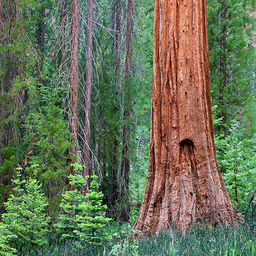

Translated Image (B)- Winter:


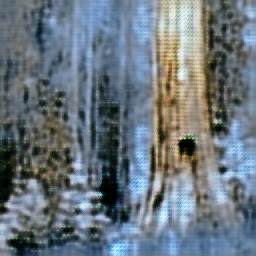

In [6]:
print(f"Image")
print("Original Image (A)- Summer:")
display(Image.open(f"results/A_to_B/real_A_27.png"))
print("Translated Image (B)- Winter:")
display(Image.open(f"results/A_to_B/fake_B_27.png"))

Image
Original Image (B)-winter:


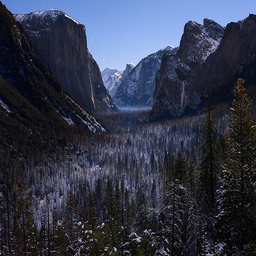

Translated Image (A)-summer:


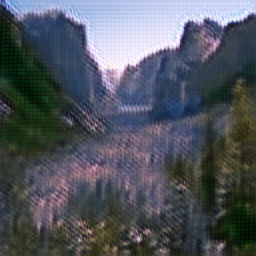

In [7]:
print(f"Image")
print("Original Image (B)-winter:")
display(Image.open(f"results/B_to_A/real_B_177.png"))
print("Translated Image (A)-summer:")
display(Image.open(f"results/B_to_A/fake_A_177.png"))

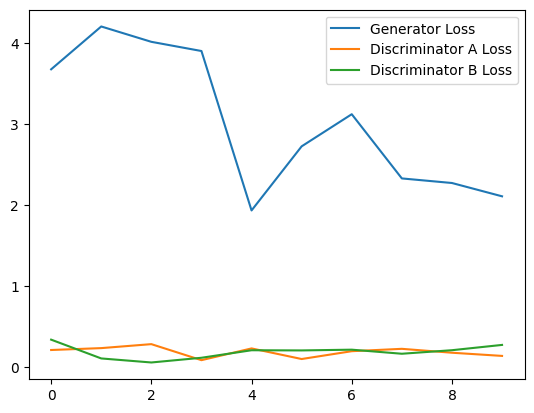

In [8]:
plt.plot(loss_gen, label='Generator Loss')
plt.plot(loss_dis_A, label='Discriminator A Loss')
plt.plot(loss_dis_B, label='Discriminator B Loss')
plt.legend()
plt.show()